## Recurrent Neural Network (RNN) Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tensorflow_addons.metrics import RSquare
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Activation, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

2023-05-18 20:25:52.994426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martijndevries/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


We start by loading in the dataframe that was created in the EDA notebook

In [2]:
df = pd.read_csv('../data/NSRDB_to_model.csv')

Next we define the features. 'Cloud Type' is a special case, as it is a categorical variable that should be one hot encoded

In [3]:
num_features = ['Wind_x', 'Wind_y', 'Dew Point', 'Day Seasonality', 'Year Seasonality', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle']
cloudtypes = to_categorical(df['Cloud Type'])

We will scale 'GHI' with a separate standardscaler, so that we can easily transform model outputs back with this particular scaler. The cloudtypes dont have to be scaled, as they are one-hot-encoded with the to_categorical function

In [44]:
stacked_data = np.hstack([df[num_features].values])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(stacked_data)
ss_y = StandardScaler() #using a separate transformer for GHI so I can easily transform back afterwards
stacked_tot = np.hstack([stacked_sc[:,:], cloudtypes[:,:], ss_y.fit_transform(df[['GHI']].values)])

In [45]:
def split_sequences(data_in, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(data_in.shape[0]):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > data_in.shape[0]:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data_in[i:end_ix, :-1], data_in[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 192, 24
# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

In [46]:
split_point = 1300 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 19), (62400, 24), (25082, 192, 19), (25082, 24))

In [7]:
#working model
lstm_model = Sequential()
lstm_model.add(LSTM(32,return_sequences=True, input_shape=(n_steps_in, nr_features)))
lstm_model.add(LSTM(16))

lstm_model.add(Dense(n_steps_out))

2023-05-18 20:26:04.489900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#optimizer learning rate
opt = Nadam(learning_rate=0.0005)
es = EarlyStopping(patience=5)
lstm_model.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [11]:
history = lstm_model.fit(train_X , train_y, batch_size=1000, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
63/63 [==============================] - 21s 338ms/step - loss: 0.0942 - r_square: 0.9068 - val_loss: 0.1018 - val_r_square: 0.8959
Epoch 2/90
63/63 [==============================] - 21s 337ms/step - loss: 0.0594 - r_square: 0.9412 - val_loss: 0.0617 - val_r_square: 0.9369
Epoch 3/90
63/63 [==============================] - 21s 330ms/step - loss: 0.0518 - r_square: 0.9487 - val_loss: 0.0619 - val_r_square: 0.9367
Epoch 4/90
63/63 [==============================] - 21s 329ms/step - loss: 0.0510 - r_square: 0.9496 - val_loss: 0.0618 - val_r_square: 0.9368
Epoch 5/90
63/63 [==============================] - 21s 329ms/step - loss: 0.0493 - r_square: 0.9513 - val_loss: 0.0621 - val_r_square: 0.9366
Epoch 6/90
63/63 [==============================] - 21s 332ms/step - loss: 0.0492 - r_square: 0.9513 - val_loss: 0.0644 - val_r_square: 0.9342
Epoch 7/90
63/63 [==============================] - 21s 329ms/step - loss: 0.0499 - r_square: 0.9507 - val_loss: 0.0642 - val_r_square: 0.9344

In [47]:
preds_train = lstm_model.predict(train_X)
preds_test = lstm_model.predict(test_X)

784/784 [==============================] - 13s 17ms/step


In [48]:
test_y_ghi = ss_y.inverse_transform(test_y)
preds_test_ghi = ss_y.inverse_transform(preds_test)
train_y_ghi = ss_y.inverse_transform(train_y)
preds_train_ghi = ss_y.inverse_transform(preds_train)

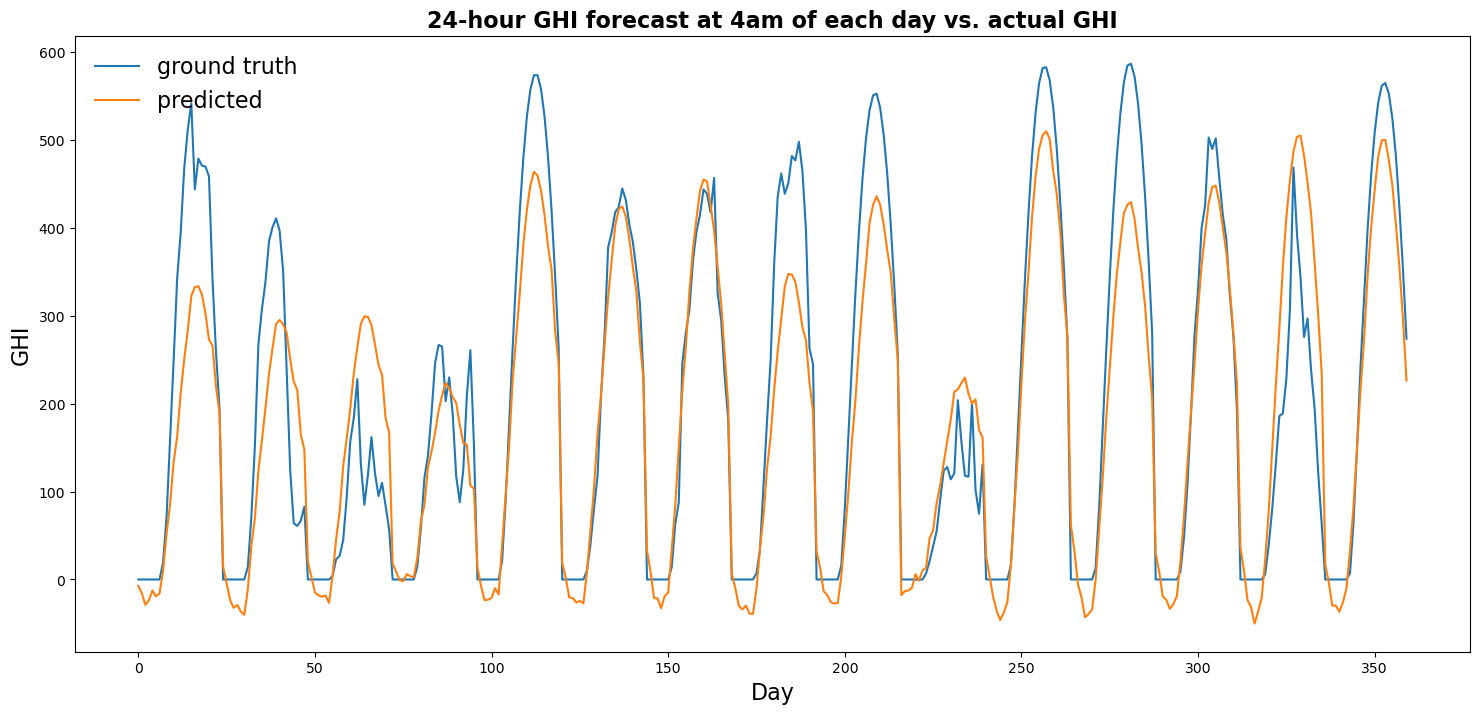

In [57]:
preds_l, test_l = [], []
x = 8
for i in range(130,145):
    test_l += list(test_y_ghi[i*48+x,:])
    preds_l += list(preds_test_ghi[i*48+x,:])
plt.figure(figsize=(18, 8))
plt.plot(test_l, label='ground truth')
plt.plot(preds_l, label='predicted')
plt.xlabel('Day', fontsize=16)
plt.ylabel('GHI', fontsize=16)
plt.title('24-hour GHI forecast at 4am of each day vs. actual GHI', fontweight='bold', fontsize=16)
plt.savefig('../figures/GHI_RNN_m1.png')
plt.legend(frameon=False, fontsize=16);

In order to evaluate our model, we will only use points where the solar zenith angle is above 90.

Filtering these points in the y data is not trivial, because of the way the data is split up into time sequences

In [15]:
train_y.shape

(62400, 24)

In [16]:
def filter_sz(sz, train_y, test_y, n_steps_in, n_steps_out, split_idx):
    
    #find all indexes where the solar zenith angle is above 90 in the OG dataframe
    sz_mask = np.where(df['Solar Zenith Angle'] < 90, 1, 0)
    train_y_mask = np.zeros(train_y.shape)
    test_y_mask = np.zeros(test_y.shape)
    
    #now loop over each batch in train_y and make a mask
    for i in range(train_y.shape[0]):
        start = i + n_steps_in
        stop = i + n_steps_in + n_steps_out
        train_y_mask[i,:] = sz_mask[start:stop]
    for j in range(test_y.shape[0]):
        #print(j)
        start = j + n_steps_in + split_idx -1
        stop = j + n_steps_in + n_steps_out + split_idx -1
        try:
            test_y_mask[j,:] = sz_mask[start:stop]
        except:
            print(j, start, stop)
    return train_y_mask.astype(dtype=bool), test_y_mask.astype(dtype=bool)

In [17]:
train_y_mask, test_y_mask = filter_sz(df['Solar Zenith Angle'], train_y, test_y, n_steps_in, n_steps_out, split_point)

In [18]:
train_y_filt = train_y[train_y_mask]
test_y_filt = test_y[test_y_mask]
preds_train_filt = preds_train[train_y_mask]
preds_test_filt = preds_test[test_y_mask]

and transformed back to GHI values

In [19]:
test_y_ghi_filt = test_y_ghi[test_y_mask]
train_y_ghi_filt = train_y_ghi[train_y_mask]
preds_train_ghi_filt = preds_train_ghi[train_y_mask]
preds_test_ghi_filt = preds_test_ghi[test_y_mask]

R2 score on the filtered train and test data:

In [20]:
r2_score(train_y_filt, preds_train_filt), r2_score(test_y_filt, preds_test_filt)

(0.8987593637965281, 0.8617840214872858)

In [21]:
mean_squared_error(train_y_ghi_filt, preds_train_ghi_filt, squared=False), mean_squared_error(test_y_ghi_filt, preds_test_ghi_filt, squared=False)

(98.35881771708294, 111.1131126727644)

In [22]:
mean_absolute_error(train_y_ghi_filt, preds_train_ghi_filt), mean_absolute_error(test_y_ghi_filt, preds_test_ghi_filt)

(69.16858058947984, 76.9005456950611)

Would a polynomial feature expansion work better?

In [59]:
pf = PolynomialFeatures()
data_pf = pf.fit_transform(df[num_features])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(data_pf)

ss_y = StandardScaler()
stacked_tot = np.hstack([stacked_sc[:,:], cloudtypes[:,:], ss_y.fit_transform(df[['GHI']].values)])

In [60]:
# choose a number of time steps 
n_steps_in, n_steps_out = 192, 24
# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

In [61]:
split_point = 1300 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 65), (62400, 24), (25082, 192, 65), (25082, 24))

In [28]:
lstm_model_pf = Sequential()
lstm_model_pf.add(LSTM(32,return_sequences=True, input_shape=(n_steps_in, nr_features)))
lstm_model_pf.add(LSTM(16))

lstm_model_pf.add(Dense(n_steps_out))

In [29]:
#optimizer learning rate
opt = Nadam(learning_rate=0.0005)
es = EarlyStopping(patience=5)
lstm_model_pf.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [30]:
history_pf = lstm_model_pf.fit(train_X , train_y, batch_size=1000, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
63/63 [==============================] - 34s 493ms/step - loss: 0.9338 - r_square: 0.0759 - val_loss: 0.7565 - val_r_square: 0.2268
Epoch 2/90
63/63 [==============================] - 24s 373ms/step - loss: 0.6524 - r_square: 0.3544 - val_loss: 0.4773 - val_r_square: 0.5122
Epoch 3/90
63/63 [==============================] - 23s 370ms/step - loss: 0.4118 - r_square: 0.5924 - val_loss: 0.3050 - val_r_square: 0.6882
Epoch 4/90
63/63 [==============================] - 24s 379ms/step - loss: 0.2831 - r_square: 0.7198 - val_loss: 0.2230 - val_r_square: 0.7721
Epoch 5/90
63/63 [==============================] - 24s 388ms/step - loss: 0.2183 - r_square: 0.7840 - val_loss: 0.1794 - val_r_square: 0.8166
Epoch 6/90
63/63 [==============================] - 25s 401ms/step - loss: 0.1789 - r_square: 0.8229 - val_loss: 0.1521 - val_r_square: 0.8445
Epoch 7/90
63/63 [==============================] - 24s 381ms/step - loss: 0.1517 - r_square: 0.8498 - val_loss: 0.1323 - val_r_square: 0.8647

In [62]:
preds_train = lstm_model_pf.predict(train_X)
preds_test = lstm_model_pf.predict(test_X)

784/784 [==============================] - 14s 17ms/step


In [64]:
test_y_ghi = ss_y.inverse_transform(test_y)
preds_test_ghi = ss_y.inverse_transform(preds_test)
train_y_ghi = ss_y.inverse_transform(train_y)
preds_train_ghi = ss_y.inverse_transform(preds_train)

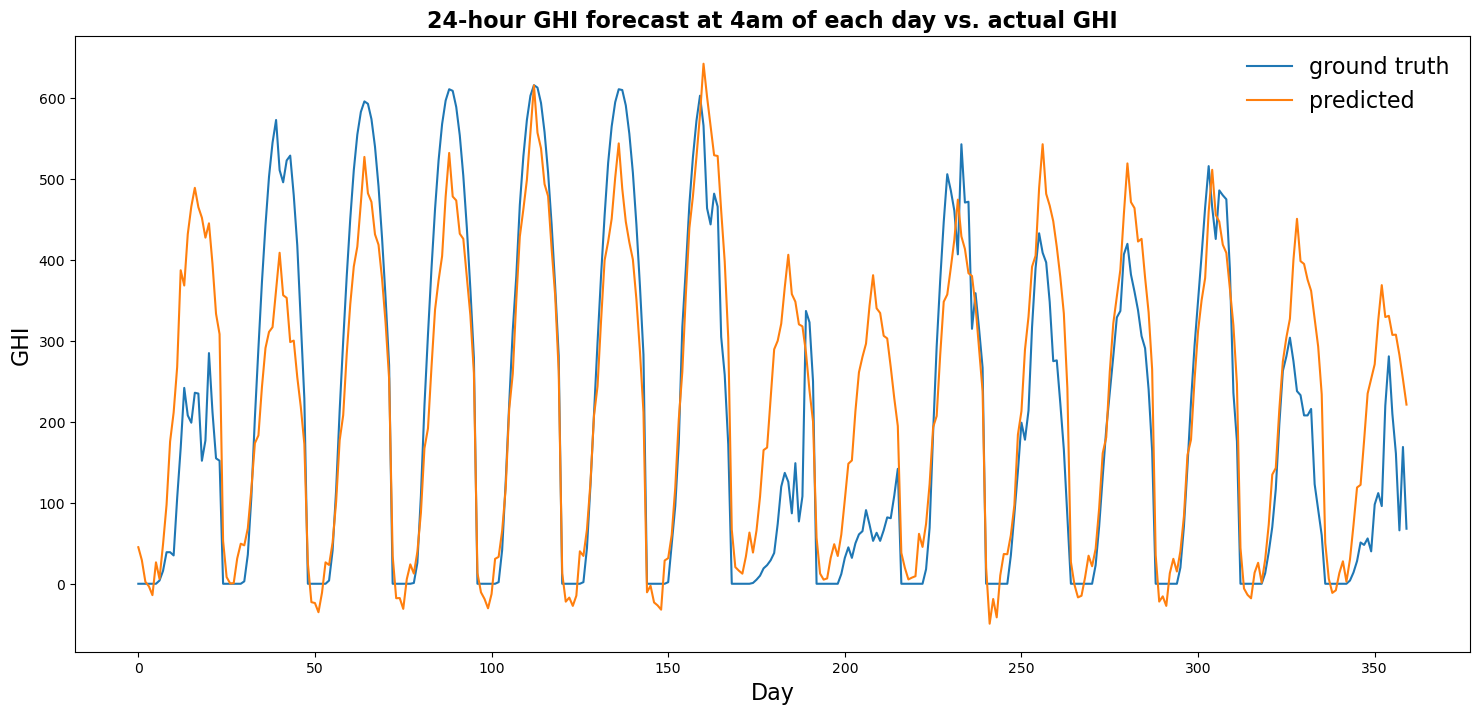

In [65]:
preds_l, test_l = [], []
x = 8 #8 timesteps after midnight, so forecast at 4am
for i in range(115,130):
    test_l += list(test_y_ghi[i*48+x,:])
    preds_l += list(preds_test_ghi[i*48+x,:])
plt.figure(figsize=(18, 8))
plt.plot(test_l, label='ground truth')
plt.plot(preds_l, label='predicted')
plt.xlabel('Day', fontsize=16)
plt.ylabel('GHI', fontsize=16)
plt.title('24-hour GHI forecast at 4am of each day vs. actual GHI', fontweight='bold', fontsize=16)
plt.savefig('../figures/GHI_RNN_m2.png')
plt.legend(frameon=False,fontsize=16)

The feature expansion model does not seem to work significantly better.

Let's evaluate the score for solar zenith angles under 90

In [66]:
train_y_mask, test_y_mask = filter_sz(df['Solar Zenith Angle'], train_y, test_y, n_steps_in, n_steps_out, split_point)

In [67]:
train_y_filt = train_y[train_y_mask]
test_y_filt = test_y[test_y_mask]
preds_train_filt = preds_train[train_y_mask]
preds_test_filt = preds_test[test_y_mask]

In [68]:
test_y_ghi_filt = test_y_ghi[test_y_mask]
train_y_ghi_filt = train_y_ghi[train_y_mask]
preds_train_ghi_filt = preds_train_ghi[train_y_mask]
preds_test_ghi_filt = preds_test_ghi[test_y_mask]

In [69]:
r2_score(train_y_filt, preds_train_filt), r2_score(test_y_filt, preds_test_filt)

(0.8979935123848766, 0.8640504847643717)

In [70]:
mean_squared_error(train_y_ghi_filt, preds_train_ghi_filt, squared=False), mean_squared_error(test_y_ghi_filt, preds_test_ghi_filt, squared=False)

(98.73014317333796, 110.19833206623981)

In [71]:
mean_absolute_error(train_y_ghi_filt, preds_train_ghi_filt), mean_absolute_error(test_y_ghi_filt, preds_test_ghi_filt)

(66.88604277062778, 72.55388142150451)